In [56]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1.Read Data File

In [42]:
dataframe = pd.read_csv("Data File/final_model_data.csv")
dataframe = dataframe.rename(columns={'mandeath':'target'})
dataframe = dataframe.drop('Unnamed: 0',axis=1)
dataframe = dataframe.drop('index',axis=1)
y = dataframe['target']
X=dataframe.drop('target',axis=1)
X=X.drop('IX',axis=1)
X=X.drop('X',axis=1)
X=X.drop('XIX',axis=1)
X=X.drop('XX',axis=1)
#X=dataframe.drop(labels=['IX','X','XIX','XX'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Training

## 3.1 Decision Tree


In [47]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [48]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(49, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [50]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=49, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [51]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [52]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.24380 | Acc: 90.718
Epoch 002: | Loss: 0.23151 | Acc: 91.194
Epoch 003: | Loss: 0.22903 | Acc: 91.340
Epoch 004: | Loss: 0.22715 | Acc: 91.365
Epoch 005: | Loss: 0.22539 | Acc: 91.444
Epoch 006: | Loss: 0.22357 | Acc: 91.501
Epoch 007: | Loss: 0.22264 | Acc: 91.503
Epoch 008: | Loss: 0.22178 | Acc: 91.536
Epoch 009: | Loss: 0.22138 | Acc: 91.561
Epoch 010: | Loss: 0.22101 | Acc: 91.603
Epoch 011: | Loss: 0.22045 | Acc: 91.595
Epoch 012: | Loss: 0.22020 | Acc: 91.591
Epoch 013: | Loss: 0.21991 | Acc: 91.608
Epoch 014: | Loss: 0.21955 | Acc: 91.615
Epoch 015: | Loss: 0.21967 | Acc: 91.629
Epoch 016: | Loss: 0.21889 | Acc: 91.649
Epoch 017: | Loss: 0.21904 | Acc: 91.627
Epoch 018: | Loss: 0.21864 | Acc: 91.644
Epoch 019: | Loss: 0.21904 | Acc: 91.665
Epoch 020: | Loss: 0.21868 | Acc: 91.666
Epoch 021: | Loss: 0.21868 | Acc: 91.662
Epoch 022: | Loss: 0.21811 | Acc: 91.684
Epoch 023: | Loss: 0.21814 | Acc: 91.691
Epoch 024: | Loss: 0.21823 | Acc: 91.684
Epoch 025: | Los

In [53]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

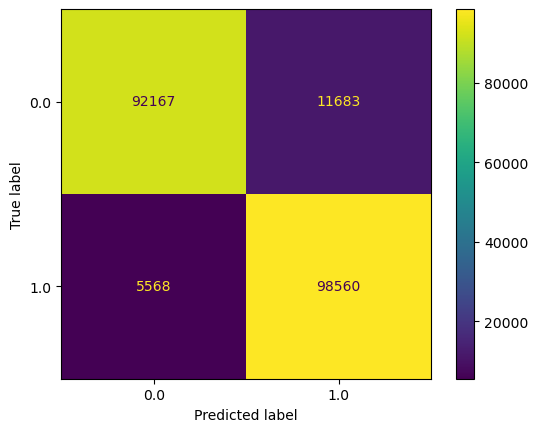

In [68]:
confusion_matrix(y_test, y_pred_list)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_list)

plt.show()

In [55]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91    103850
         1.0       0.89      0.95      0.92    104128

    accuracy                           0.92    207978
   macro avg       0.92      0.92      0.92    207978
weighted avg       0.92      0.92      0.92    207978

